In [1]:
import os
import sys
import random
import json
import collections
import re
from itertools import combinations

import pandas as pd
import numpy as np
import scipy
import statsmodels
from tqdm import trange, tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


pd.options.display.max_columns = 999

pd.options.display.max_rows = 100

sns.set()
plt.rcParams["figure.figsize"] = (10,7)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sigmod_src.make_dataset import make_specs_dataset
from sigmod_src.preprocessing import preprocess_specs_dataset
from sigmod_src.pipeline import LGBMPipeline
from sigmod_src.utils import get_additional_labels, make_classes_df

In [4]:
LG_LABELS_PATH = '../data/raw/sigmod_large_labelled_dataset.csv'
SPECS_PATH = '../data/raw/2013_camera_specs/'

# Load labels df

In [5]:
labels_df = pd.read_csv(LG_LABELS_PATH)
labels_df.shape

(297651, 3)

# Load specs df

In [6]:
specs_dataset_src = make_specs_dataset(SPECS_PATH)

In [7]:
specs_dataset_src.shape

(29787, 7)

In [544]:
specs_df = preprocess_specs_dataset(specs_dataset_src)

Dropping 87 known non-camera brand specs
Dropping 2296 camera bag specs
Dropping 4006 cctv specs
Warning, dropped 9 rows containing null page titles


In [8]:
specs_df.shape

(23389, 10)

In [547]:
new_dups = additional_labels[additional_labels.label==1]
new_dups.head()

,left_spec_id,right_spec_id,label
0,www.ebay.com//45356,www.ebay.com//43231,1
1,www.ebay.com//46559,www.ebay.com//24325,1
2,www.ebay.com//53122,www.ebay.com//44489,1
3,www.ebay.com//53122,www.ebay.com//53584,1
4,www.ebay.com//53122,www.ebay.com//25103,1


In [12]:
sample = specs_df.sample(5)
sample[['spec_id', 'page_title_stem', 'brand', 'model', 'type']].values

array([['www.ebay.com//58739',
        'sealif reefmast dedic digit dive dc310 0077068411499',
        'sealife', None, 'underwater'],
       ['www.ebay.com//60523',
        'aiptek pocketcam classic 0-3-mp digit 653886000994', 'aiptek',
        None, 'point shoot'],
       ['www.ebay.com//47827', 'olympus fe 46 12-0-mp digit pink',
        'olympus', 'fe46', 'point shoot'],
       ['www.ebay.com//52770', 'soni cyber shot dsc w70 7-2-mp digit',
        'sony', 'dscw70', 'point shoot'],
       ['www.ebay.com//54745',
        'olympus fe 190 6-0-mp digit repair part charger', 'olympus',
        'fe190', 'point shoot']], dtype=object)

In [13]:
specs_df.brand.value_counts(dropna=False)[:10]

canon        5521
nikon        4742
sony         3035
NaN          1628
fujifilm     1510
olympus      1451
panasonic    1302
samsung      1023
kodak         765
pentax        667
Name: brand, dtype: int64

In [14]:
specs_df.model.value_counts(dropna=False)[:10]

NaN      10135
t3i        208
d3200      193
60d        170
d3100      158
d5200      145
70d        139
d5100      137
d7000      137
1100d      133
Name: model, dtype: int64

In [567]:
specs_df.type.value_counts(dropna=False)[:10]

point shoot    7511
NaN            6659
dslr           5756
compact        1340
mirrorless     1104
bridge          619
underwater      400
Name: type, dtype: int64

In [568]:
specs_df.megapixels.value_counts(dropna=False)[:10]

NaN        5575
16-mp      1016
6-mp        993
12-1-mp     881
16-1-mp     822
14-mp       763
18-mp       744
8-mp        696
10-mp       665
12-mp       644
Name: megapixels, dtype: int64

In [569]:
specs_df.to_csv('../data/processed/specs.csv', index=None)

In [15]:
sample = new_non_dups.sample(1)

print('Left\n', specs_df.loc[sample.left_spec_id].page_title_stem.values[0])
print('')
print('Right\n', specs_df.loc[sample.right_spec_id].page_title_stem.values[0])

Left
 nikon d50 6 1mp digit slr sigma apo 170 500mm telephoto len bundl

Right
 seal nikon coolpix s31 10 1mp digit


# Test pipeline

In [18]:
model = LGBMPipeline(specs_df, labels_df)

In [21]:
model.precompute()

1272it [00:00, 5628.80it/s]
100%|██████████| 43/43 [01:43<00:00,  2.40s/it]


In [22]:
%%time
train_left_spec_idx = model.specs_id_to_idx[labels_df['left_spec_id']]
train_right_spec_idx = model.specs_id_to_idx[labels_df['right_spec_id']]

train_X = make_X(model, train_left_spec_idx, train_right_spec_idx)

assert train_X.shape[0] == labels_df.shape[0]

NameError: name 'make_X' is not defined

In [ ]:
new_non_dups = additional_labels[additional_labels.label==0]
new_non_dups.shape

In [ ]:
sample = new_non_dups.sample(1)

print('Left\n', specs_df.loc[sample.left_spec_id].page_title_stem.values[0])
print('')
print('Right\n', specs_df.loc[sample.right_spec_id].page_title_stem.values[0])

# Test pipeline

In [628]:
model = LGBMPipeline(specs_df, labels_df)

In [629]:
model.labels

array([1, 0, 0, ..., 0, 0, 0])

In [630]:
model.precompute()


0it [00:00, ?it/s]
492it [00:00, 4913.42it/s]
807it [00:00, 4202.79it/s]
1325it [00:00, 4454.11it/s]
1399it [00:00, 4457.42it/s]
100%|██████████| 34/34 [00:01<00:00, 26.05it/s]

In [631]:
x = model.make_X([0, 2], [1, 3])
x.shape

(2, 24)

In [635]:
model.train(precompute=False)

Precomputing
Making features
Making features for additional_labels
Fitting model


In [120]:
pred_train = model.clf.predict(model.train_X)

print('Train F1', f1_score(labels_df.label, pred_train))
print(classification_report(labels_df.label, pred_train))

Train F1 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    253612
           1       1.00      1.00      1.00     44039

    accuracy                           1.00    297651
   macro avg       1.00      1.00      1.00    297651
weighted avg       1.00      1.00      1.00    297651



In [637]:
additional_left_spec_idx = model.specs_id_to_idx[model.additional_df['left_spec_id']]
additional_right_spec_idx = model.specs_id_to_idx[model.additional_df['right_spec_id']]

additional_X = model.make_X(additional_left_spec_idx, additional_right_spec_idx)

additional_Y = model.additional_df.label

pred_additional = model.clf.predict(additional_X)

print('F1 on additional labels', f1_score(additional_Y, pred_additional))
print(classification_report(additional_Y, pred_additional))

F1 on additional labels 0.5026176428371772
              precision    recall  f1-score   support

           0       0.90      0.99      0.94    541252
           1       0.87      0.35      0.50     93987

    accuracy                           0.90    635239
   macro avg       0.88      0.67      0.72    635239
weighted avg       0.89      0.90      0.88    635239



Sanity check passed

# Feature importance

In [124]:
import shap

In [125]:
explainer = shap.TreeExplainer(model.clf)

In [126]:
shap_values = explainer.shap_values(model.train_X)

In [127]:
feature_names = ['n_common_tokens', 
                    'n_common_tokens_normed',
                    'sum_len_common_tokens',
                    'special_sum_len_common_tokens',
                    'special_n_common_tokens',
                    'number_sum_len_common_tokens',
                    'number_n_common_tokens',

                    'n_common_symbols_models', 'same_model',

                    'n_common_symbols_types', 'same_type',

                    'n_common_symbols_megapixels', 'same_megapixels',

                    'lev_ratios',

                    'jaccard_sim',
                    'n_common_symbols',

                    'n_common_neighboors', 'n_common_neighboors_normed',

                    'site_left', 'site_right', 'brand_left', 'brand_right',
                   'same_brand', 'same_site',
                   ]

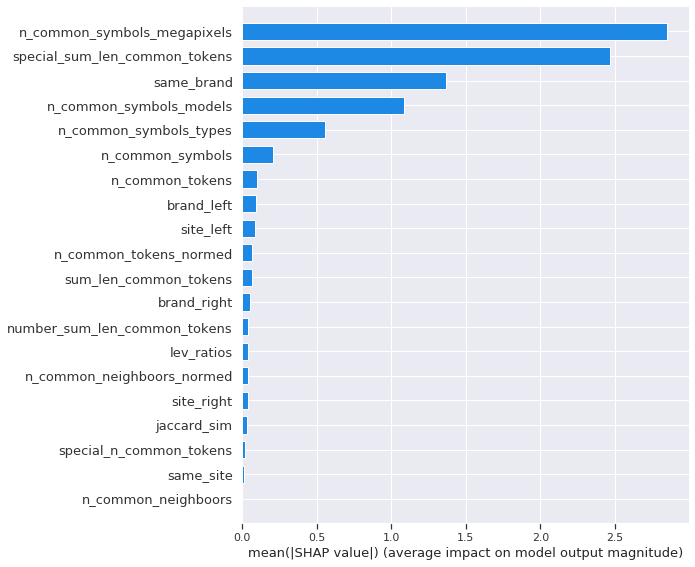

In [128]:
shap.summary_plot(shap_values, model.train_X, plot_type="bar", feature_names=feature_names)

# Submit

In [46]:
model.make_submission()



  0%|          | 0/63 [00:00<?, ?it/s]

  2%|▏         | 1/63 [00:00<00:40,  1.54it/s]

  8%|▊         | 5/63 [04:27<19:47, 20.47s/it]

 10%|▉         | 6/63 [04:28<13:46, 14.51s/it]

 24%|██▍       | 15/63 [04:28<08:07, 10.16s/it]

 24%|██▍       | 15/63 [04:47<08:07, 10.16s/it]

 25%|██▌       | 16/63 [04:54<11:39, 14.89s/it]

 30%|███       | 19/63 [04:54<07:41, 10.48s/it]

 38%|███▊      | 24/63 [05:00<04:59,  7.69s/it]

 41%|████▏     | 26/63 [05:01<03:22,  5.46s/it]

 51%|█████     | 32/63 [09:28<08:53, 17.22s/it]

 56%|█████▌    | 35/63 [12:45<14:47, 31.71s/it]

 57%|█████▋    | 36/63 [13:10<13:18, 29.58s/it]

 60%|██████    | 38/63 [13:29<09:50, 23.62s/it]

 62%|██████▏   | 39/63 [13:34<07:08, 17.87s/it]

 65%|██████▌   | 41/63 [13:34<04:35, 12.54s/it]

 68%|██████▊   | 43/63 [13:34<02:56,  8.80s/it]

 71%|███████▏  | 45/63 [13:48<02:27,  8.21s/it]

 79%|███████▉  | 50/63 [13:48<01:14,  5.76s/it]

 83%|████████▎ | 52/63 [15:59<04:21, 23.77s/it]

 90%|█████████ | 57/63 [16:00<

In [50]:
submit_df = pd.read_csv('../data/submit/submit.csv')
submit_df.shape

(533397, 2)

In [51]:
specs_df.index = specs_df.spec_id

In [55]:
row = submit_df.sample(1)

print('Left\n', specs_df.loc[row.left_spec_id].page_title.values[0])
print('')
print('Right\n', specs_df.loc[row.right_spec_id].page_title.values[0])

Left
 canon eos rebel t3i 600d 18-0-mp digital slr kit w ef

Right
 canon eos rebel t3i cmos digital slr sale 474 95


# CV

In [19]:
from tqdm.notebook import tqdm

In [20]:
def get_split(classes_df, labels_df, test_classes=5):
    classes = classes_df.class_.unique()
    test_classes = np.random.choice(classes, test_classes)
    
    test_spec_ids = classes_df[classes_df.class_.isin(test_classes)].spec_id
    
    test_label_mask = labels_df.left_spec_id.isin(test_spec_ids) | labels_df.right_spec_id.isin(test_spec_ids)
    
    test_idx = np.array(labels_df[test_label_mask].index)
    train_idx = np.array(labels_df[~test_label_mask].index)
    
    return train_idx, test_idx

def evaluate_submit(submit_df, test_labels_df):
    submit_df = submit_df.copy()
    submit_df['label'] = 1
    
    merged = test_labels_df.merge(submit_df, on=['left_spec_id', 'right_spec_id'], how='left', suffixes = ('_true', '_pred'))
    merged['label_pred'] = merged['label_pred'].fillna(0)
    
    tp = merged[(merged.label_true == 1) & (merged.label_pred == 1)]
    tn = merged[(merged.label_true == 0) & (merged.label_pred == 0)]
    
    fp = merged[(merged.label_true == 0) & (merged.label_pred == 1)]
    fn = merged[(merged.label_true == 1) & (merged.label_pred == 0)]
    
    precision = tp.shape[0]/(tp.shape[0]+fp.shape[0])
    recall = tp.shape[0]/(tp.shape[0]+fn.shape[0])
    
    f1 = 2 * (precision * recall)/(precision+recall)
    
    return f1, tp, tn, fp, fn

def cross_validate_pipeline(pipeline_class, specs_df, labels_df, clfs, n_folds=5, test_classes=5):
    # Obtain triangles from label and number them
    classes_df = make_classes_df(labels_df)
    folds = []
    submit_fpaths = []
    scores = []
    for i_fold in tqdm(range(n_folds)):
        print('Fold', i_fold)
        labels_train_idx, labels_test_idx = get_split(classes_df, labels_df, test_classes=test_classes)
        folds.append( (labels_train_idx, labels_test_idx) )
        
        train_labels = labels_df.iloc[labels_train_idx].copy()
        test_labels = labels_df.iloc[labels_test_idx].copy()
        
        submit_fpath = f'../data/interim/cv_submit_fold{i_fold}.csv'
        submit_fpaths.append(submit_fpath)
        
        model = pipeline_class(specs_df, train_labels, submit_fpath=submit_fpath)
        print('training model')
        model.train(clfs=clfs)
        
        print('generating submit')
        model.make_submission()
        
        print('evaluating submit')
        f1score, _, _, _, _ = evaluate_submit(pd.read_csv(model.submit_fpath), test_labels)
        scores.append(f1score)
        print('Score', f1score)
    return folds, submit_fpaths, scores

In [21]:
clfs = [
    LGBMClassifier(sample_pos_weight=5.76, n_jobs=-1),
    LGBMClassifier(sample_pos_weight=5.76, n_estimators=500, n_jobs=-1),
    LGBMClassifier(sample_pos_weight=5.76, learning_rate=0.01, n_jobs=-1),
    LGBMClassifier(sample_pos_weight=5.76, learning_rate=0.01, n_estimators=500, n_jobs=-1),
    
]

In [ ]:
# np.random.seed(42)
np.random.seed(None)
folds, submit_fpaths, scores = cross_validate_pipeline(LGBMPipeline, specs_df, labels_df, clfs, n_folds=3)

In [23]:
scores

[0.43317311141401826, 0.5178181818181818, 0.6896355353075171]

In [24]:
np.mean(scores)

0.5468756095132391

## Test evaluation scheme

In [25]:
np.mean(scores)

0.43317311141401826

## Test evaluation scheme

In [ ]:

    
    
test_labels_df = labels_df.iloc[folds[0][1]]
submit_df = pd.read_csv(submit_fpaths[0])

score, tp, tn, fp, fn = evaluate_submit(submit_df, test_labels_df)
score

Test one true positive

In [ ]:
tp.head()

In [27]:
test_labels_df[test_labels_df.label == 1][test_labels_df.left_spec_id == 'www.ebay.com//24206']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,left_spec_id,right_spec_id,label


In [28]:
submit_df[(submit_df.left_spec_id == 'www.ebay.com//24206') & (submit_df.right_spec_id == 'www.priceme.co.nz//54')]

,left_spec_id,right_spec_id


Pass

Check one tn

In [29]:
tn.head()

,left_spec_id,right_spec_id,label_true,label_pred
0,www.ebay.com//24817,www.ebay.com//58782,0,0.0
1,www.ebay.com//43019,www.ebay.com//58782,0,0.0
2,www.ebay.com//42055,www.ebay.com//54403,0,0.0
3,www.ebay.com//42039,www.ebay.com//43213,0,0.0
4,www.ebay.com//42196,www.ebay.com//58588,0,0.0


In [30]:
test_labels_df[test_labels_df.label == 0][test_labels_df.left_spec_id == 'www.ebay.com//42074'][test_labels_df.right_spec_id == 'www.ebay.com//47107']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,left_spec_id,right_spec_id,label


In [31]:
submit_df[submit_df.left_spec_id == 'www.ebay.com//42074'][submit_df.right_spec_id == 'www.ebay.com//47107']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,left_spec_id,right_spec_id


Pass

Check one fp

In [ ]:
fp.head()

In [ ]:
test_labels_df[test_labels_df.label == 0][test_labels_df.left_spec_id == 'www.ebay.com//42074'][test_labels_df.right_spec_id == 'www.ebay.com//54040']

In [ ]:
submit_df[submit_df.left_spec_id == 'www.ebay.com//42074'][submit_df.right_spec_id == 'www.ebay.com//54040']

Pass

Check one fn

In [ ]:
fn.head()

In [ ]:
test_labels_df[test_labels_df.label == 1][test_labels_df.left_spec_id == 'www.ebay.com//54040'][test_labels_df.right_spec_id == 'www.ebay.com//54457']

In [ ]:
submit_df[submit_df.left_spec_id == 'www.ebay.com//54040'][submit_df.right_spec_id == 'www.ebay.com//54457']

pass